# Network Time Series



In [1]:
__author__      = 'Roy Gardner'

%run ./network_functions.py


## Load the agreement-actor data

- Load data into a binary-valued relation matrix (BVRM) with agreements in rows and actors in columns
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one
- Apart from the matrix other data are extracted or computed
- All data are stored in data_dict


In [2]:

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)


In [34]:
print(data_dict['color_map'])

{'AGT': '#e6194b', 'ARM': '#3cb44b', 'COA': '#ffe119', 'CON': '#4363d8', 'ENT': '#f58231', 'IGO': '#911eb4', 'MIL': '#46f0f0', 'NGO': '#f032e6', 'OTH': '#bcf60c', 'POL': '#fabebe', 'UMB': '#008080'}


## Get a peace process sub-matrix

- Create the binary-valued relation matrix containing only the agreements and actors of a defined peace process.
- Data are stored in pp_data_dict


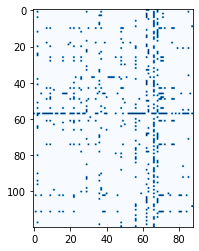

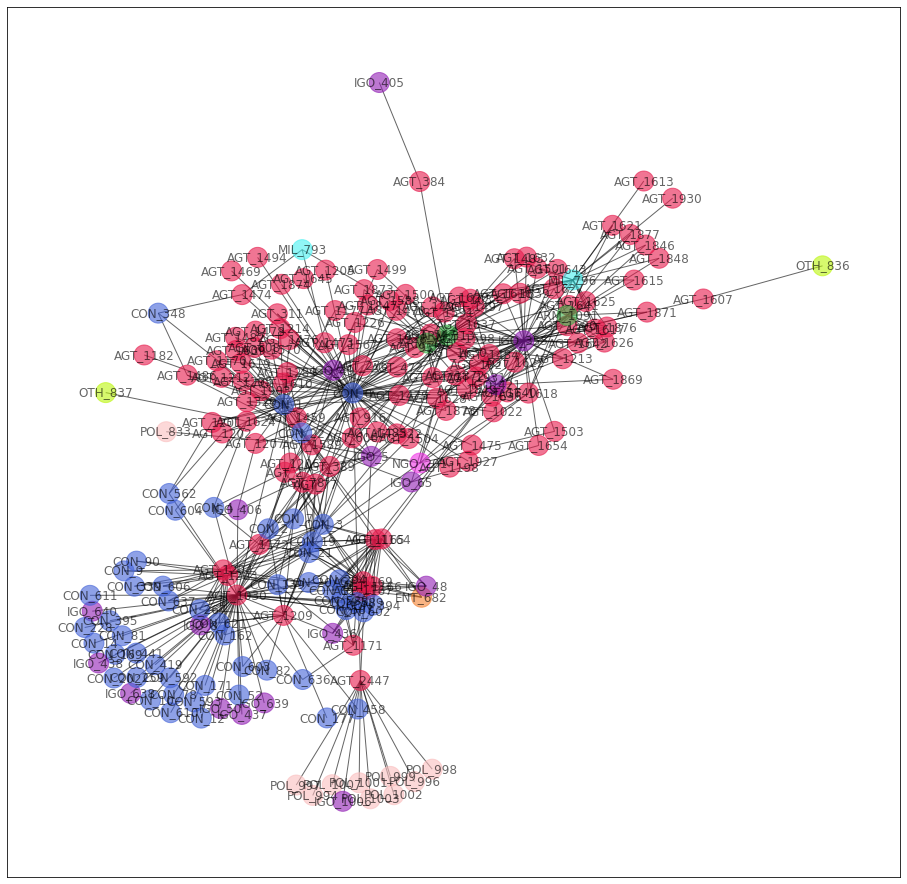

In [3]:

process_name = 'Bosnia peace process'
#process_name = 'Yemen peace process'
#process_name = 'Chad: Doha process'
#process_name = 'DRC: Eastern DRC processes'
#process_name = 'Afghanistan: 2000s Post-intervention process'
#process_name = 'Yemen Inter-group Agreements'

pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']

plt.imshow(pp_matrix,cmap=plt.cm.Blues)
plt.show()

# Display graph
adj_matrix,adj_vertices = adjacency_from_biadjacency(pp_data_dict)
#print(adj_vertices)
display_networkx_graph(adj_matrix,range(0,len(adj_vertices)),adj_vertices,data_dict)


In [6]:
print(pp_data_dict.keys())

dict_keys(['pp_actor_ids', 'pp_agreement_ids', 'pp_matrix'])


## Generate network diagrams for an actor in a peace process

Peace process analysis is just one application.

Process:

1. Get the selected actor column vector from the biadjacency matrix. This provides the agreements signed by the actor.
2. Get the dates of the agreements in the column vector. These are the dates on which the actor signed an agreement.
3. Get all agreements on these dates. There may be some agreements not signed by the actor.
4. Create at list of (date,agreement) tuples sorted by date.
5. Iterate the tuples and for each agreement get the row vector containing actors and build a set of actor. This set will contain the selected actor.
6. Add actors and agreements to a network query, obtain the query adjacency matrix, and display.


Bosnia and Herzegovina
66
1992-03-18
['AGT_547']


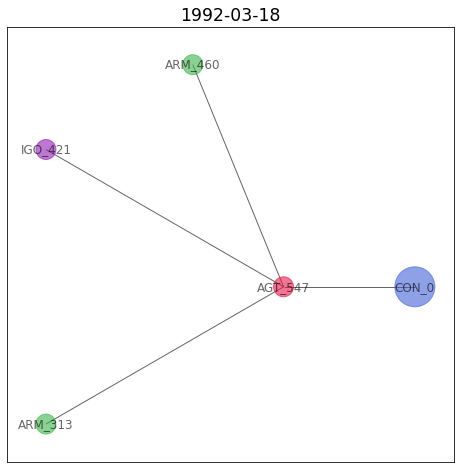

1992-04-12
['AGT_1470']


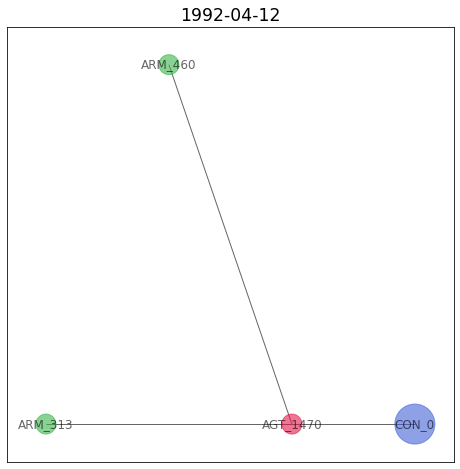

1992-05-05
['AGT_1588']


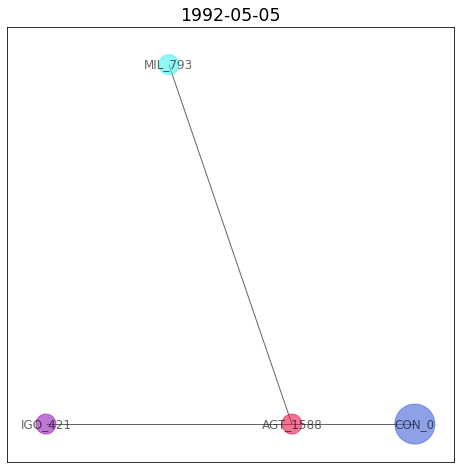

1992-05-10
['AGT_1473']


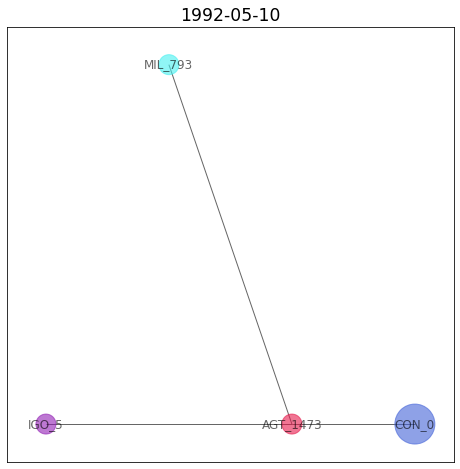

1992-05-18
['AGT_1474']


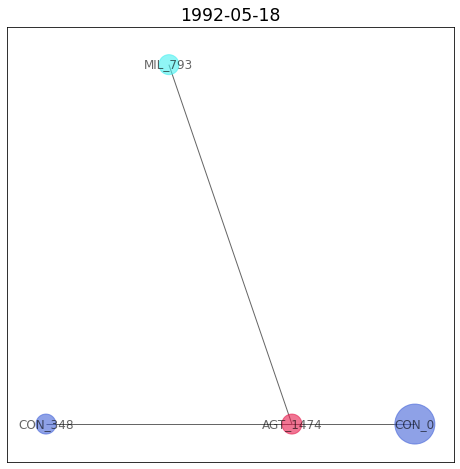

1992-05-22
['AGT_1475']


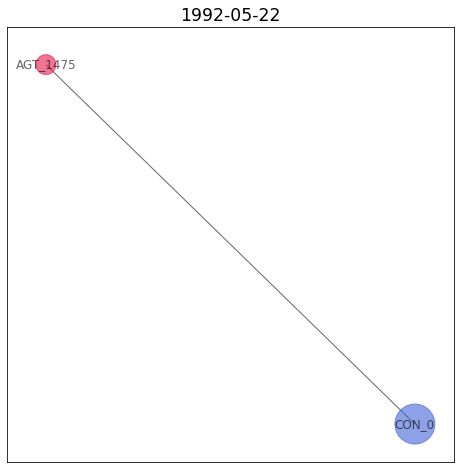

1992-05-23
['AGT_1927']


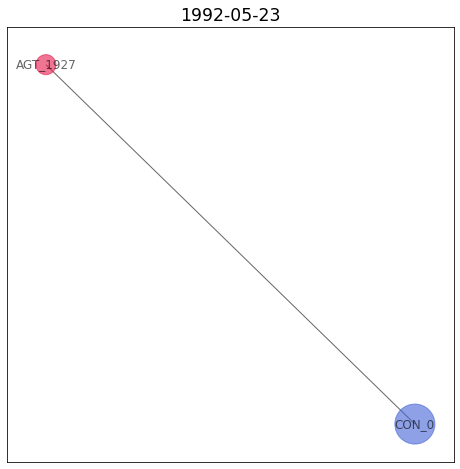

1992-06-01
['AGT_1591', 'AGT_1590']


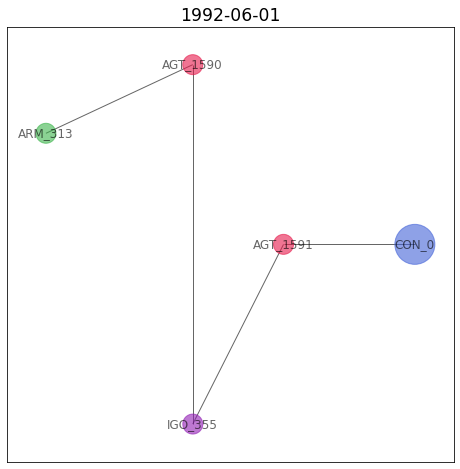

1992-06-05
['AGT_1022']


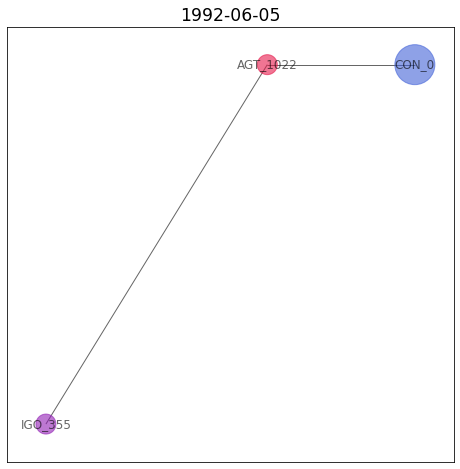

1992-06-06
['AGT_1589']


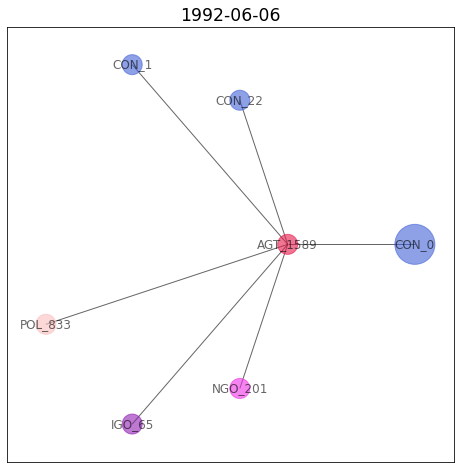

1992-06-15
['AGT_1570']


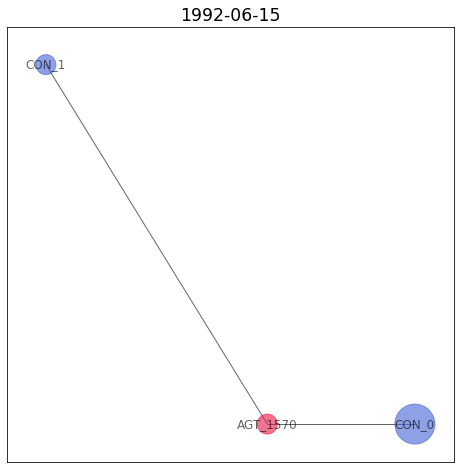

1992-07-08
['AGT_1476']


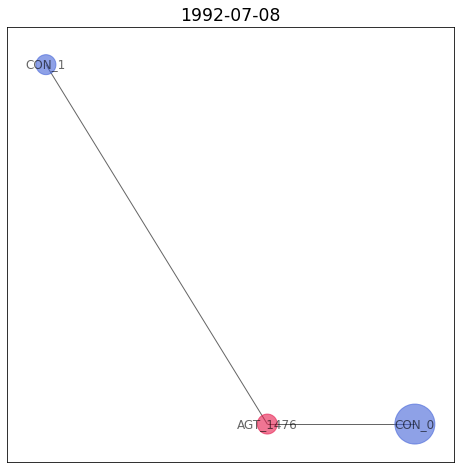

1992-07-17
['AGT_1477']


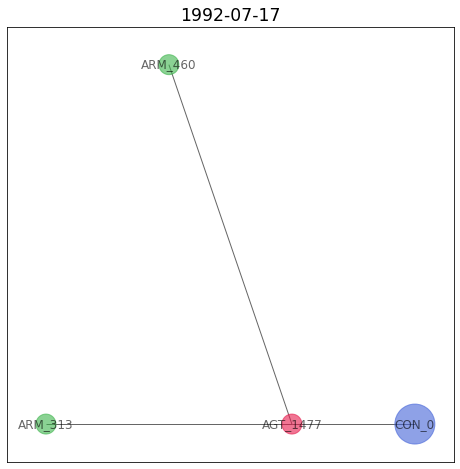

1992-07-21
['AGT_1478']


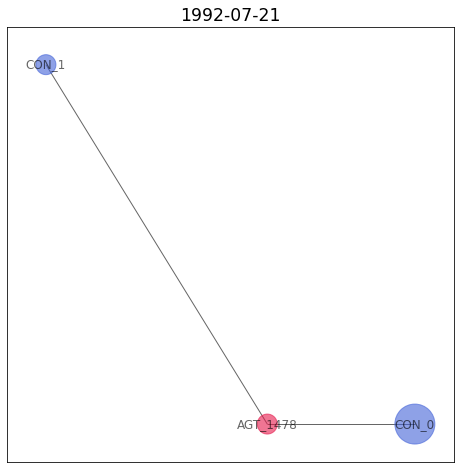

1992-09-19
['AGT_1567']


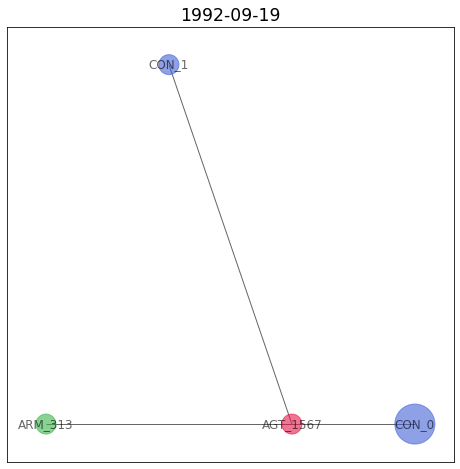

1992-09-23
['AGT_1609']


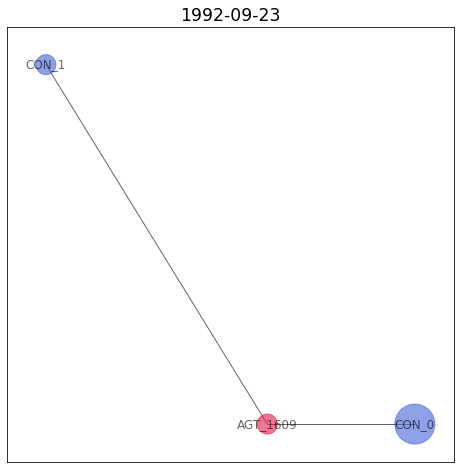

1992-10-01
['AGT_1610']


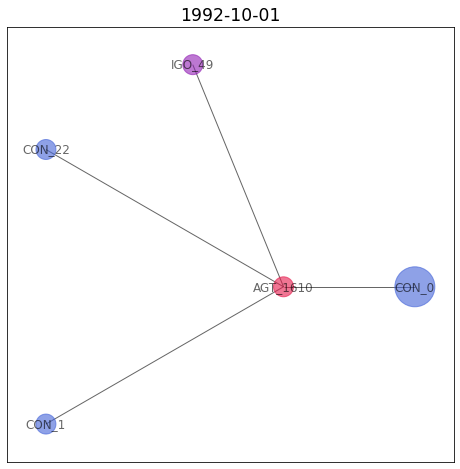

1992-10-19
['AGT_1479']


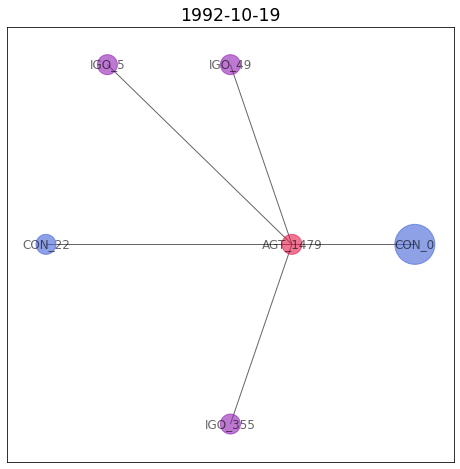

1993-03-27
['AGT_1619']


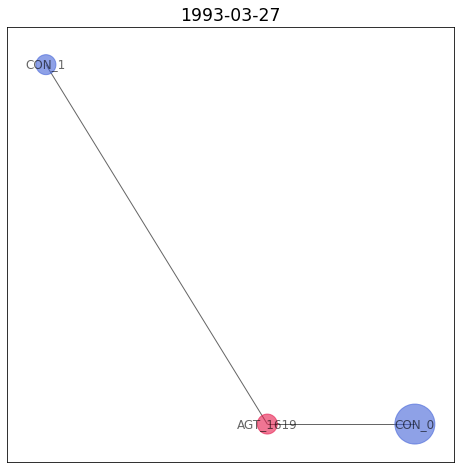

1993-04-18
['AGT_1027']


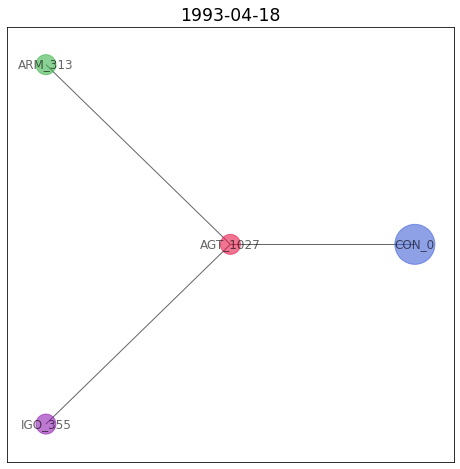

1993-04-25
['AGT_1482']


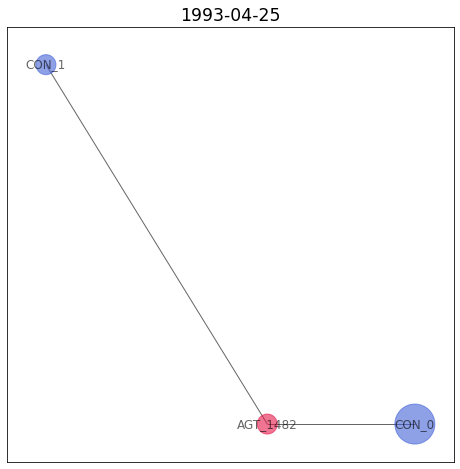

1993-05-02
['AGT_606']


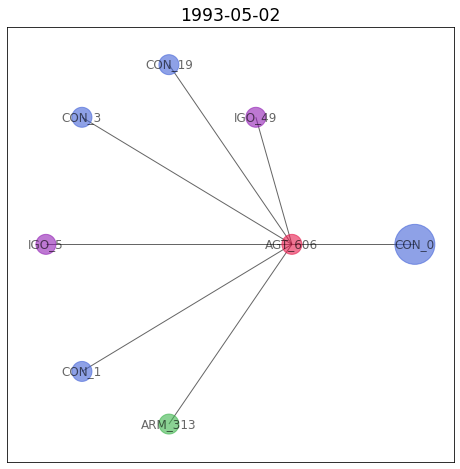

1993-05-18
['AGT_1624']


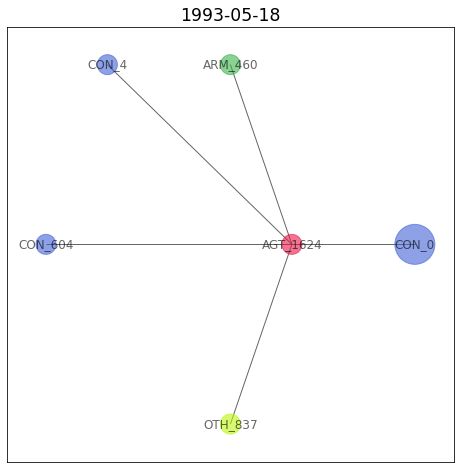

1993-05-21
['AGT_1847']


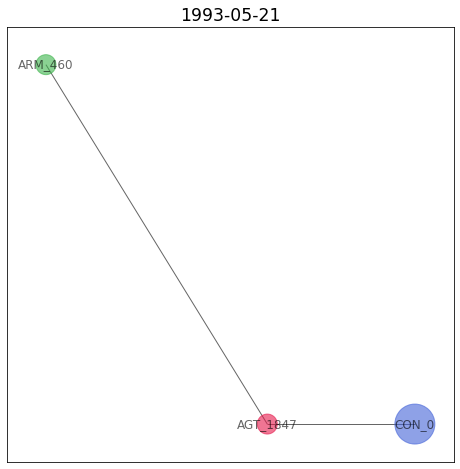

1993-07-10
['AGT_1628']


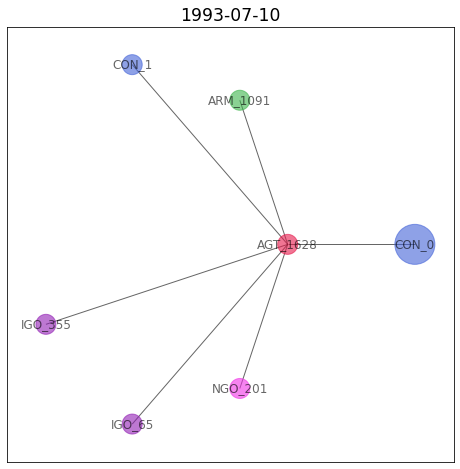

1993-07-12
['AGT_1485']


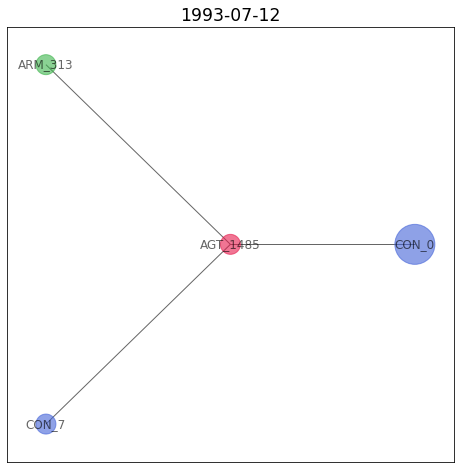

1993-08-14
['AGT_1490']


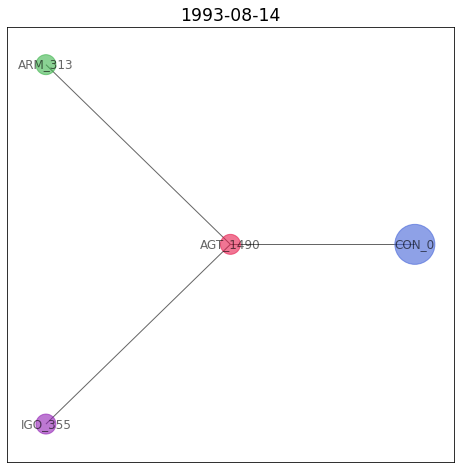

1993-08-31
['AGT_1630']


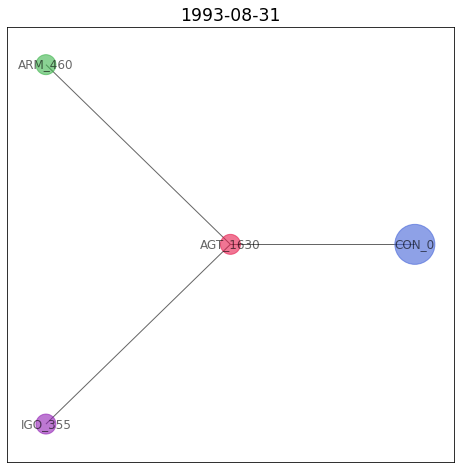

1993-09-16
['AGT_472']


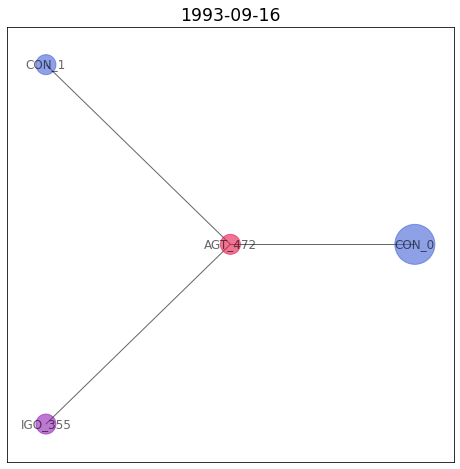

1993-11-12
['AGT_1202']


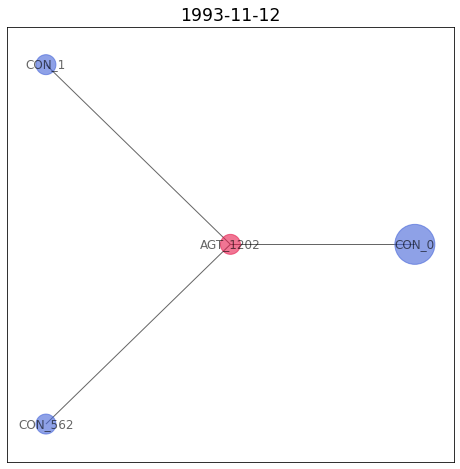

1993-12-16
['AGT_1849']


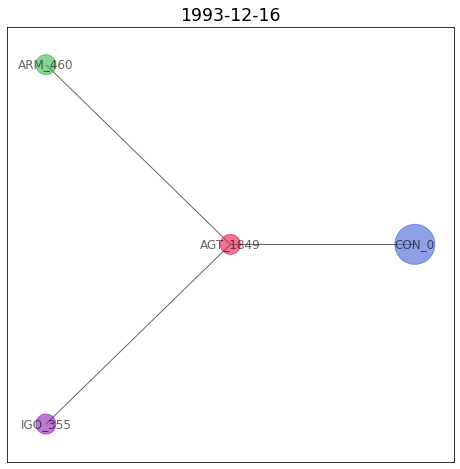

1994-01-26
['AGT_1598']


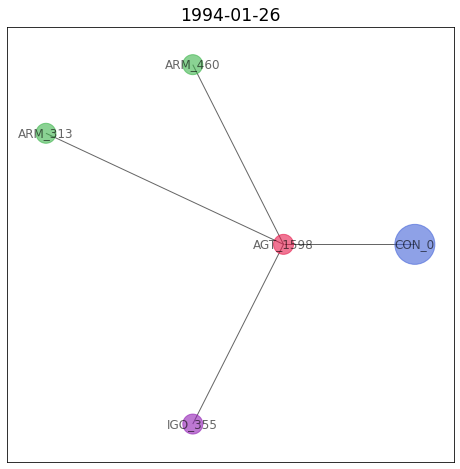

1994-02-08
['AGT_1872', 'AGT_1930']


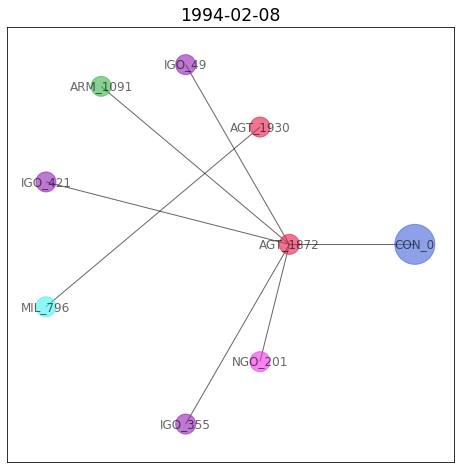

1994-02-19
['AGT_1931']


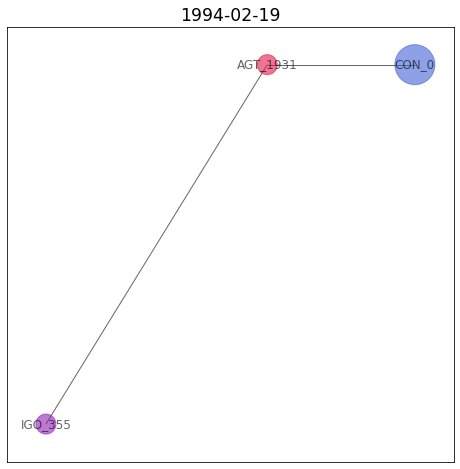

1994-03-01
['AGT_608']


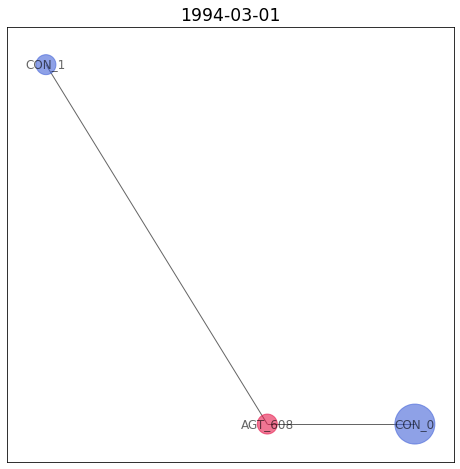

1994-03-12
['AGT_1878']


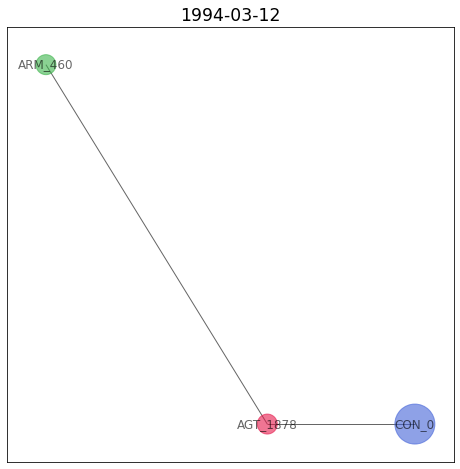

1994-03-17
['AGT_1636']


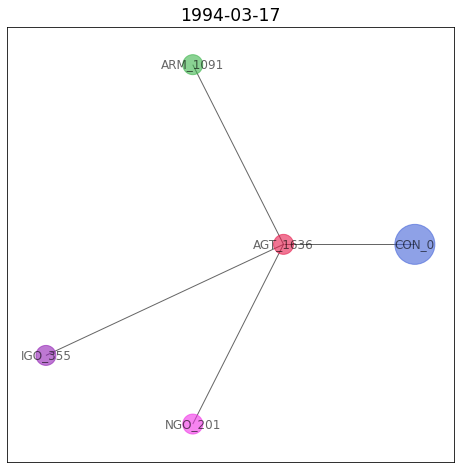

1994-03-18
['AGT_1198']


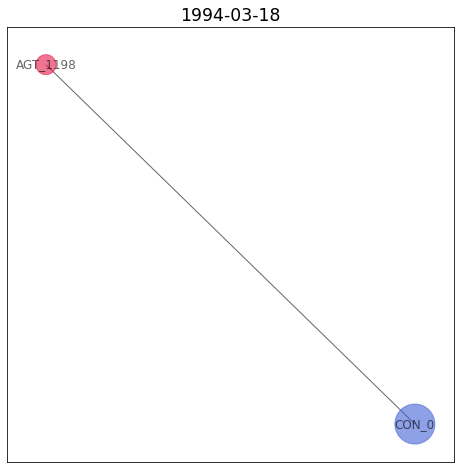

1994-05-11
['AGT_1873']


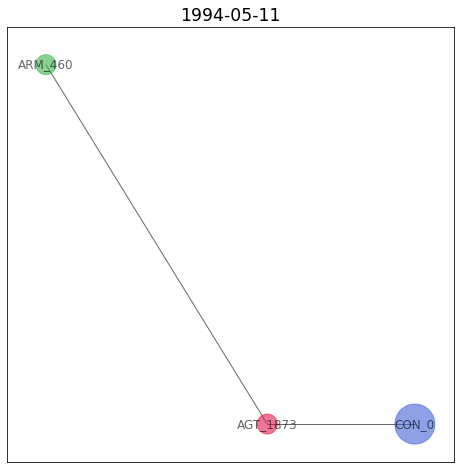

1994-05-21
['AGT_1637']


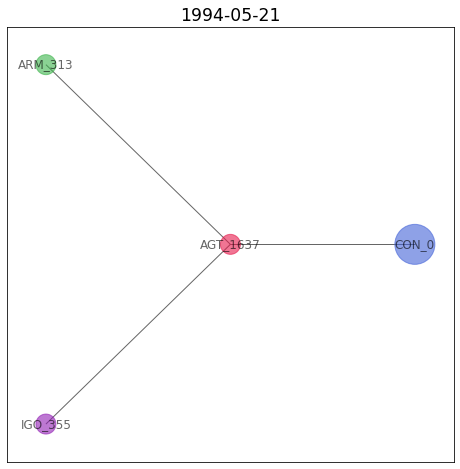

1994-06-08
['AGT_1500']


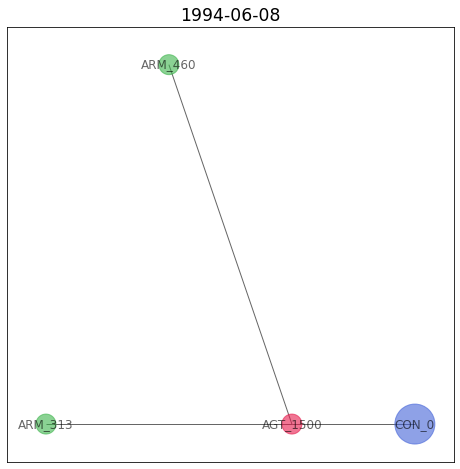

1994-07-12
['AGT_1226']


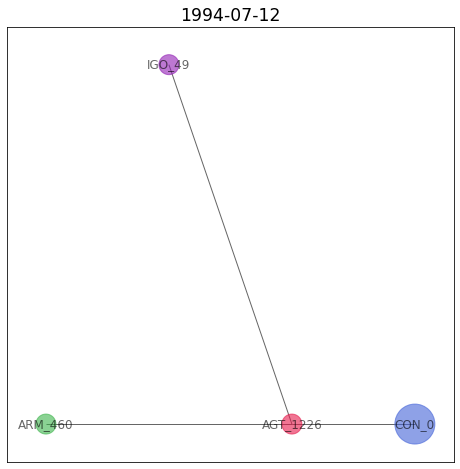

1994-12-21
['AGT_1504']


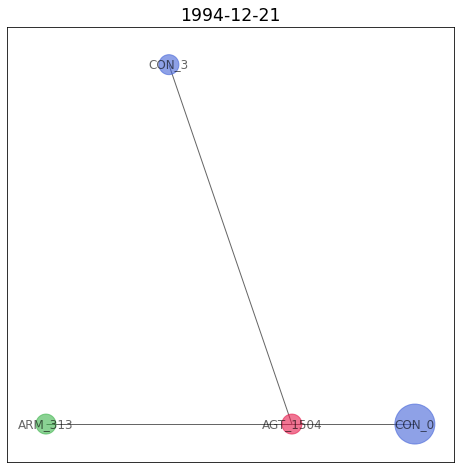

1994-12-23
['AGT_916']


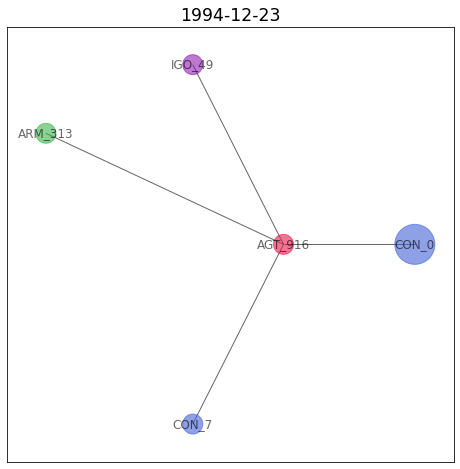

1994-12-31
['AGT_915']


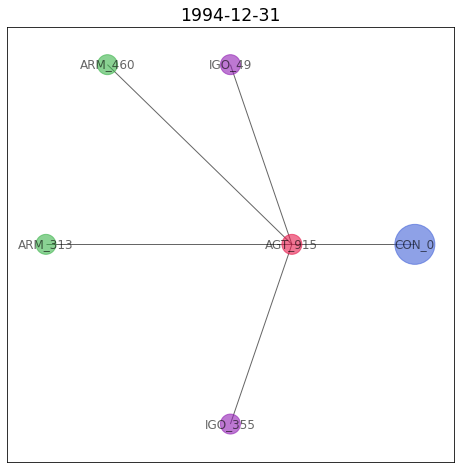

1995-01-23
['AGT_1640']


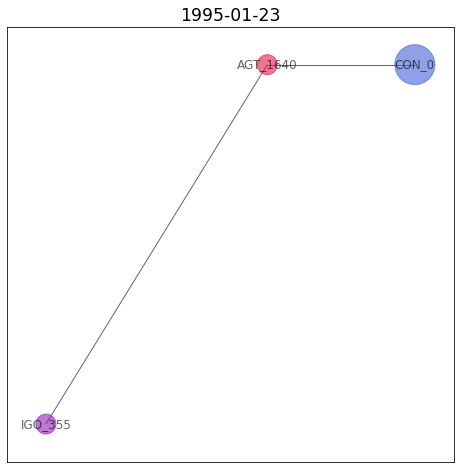

1995-04-06
['AGT_1874']


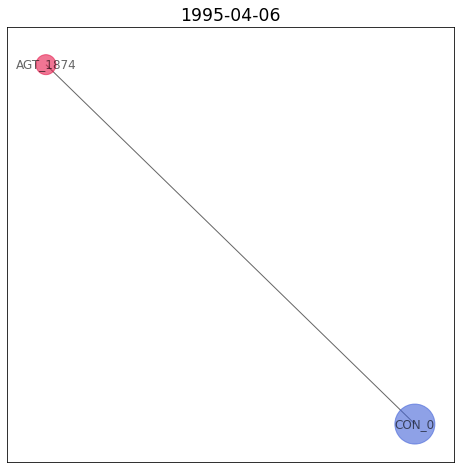

1995-07-22
['AGT_1214']


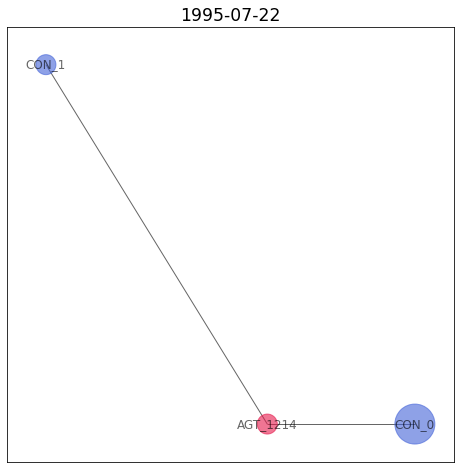

1995-09-08
['AGT_77']


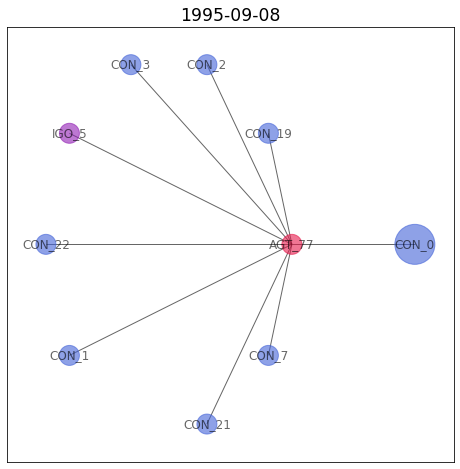

1995-09-26
['AGT_78']


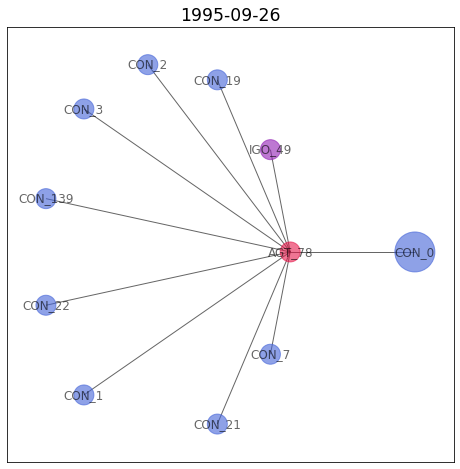

1995-10-05
['AGT_322']


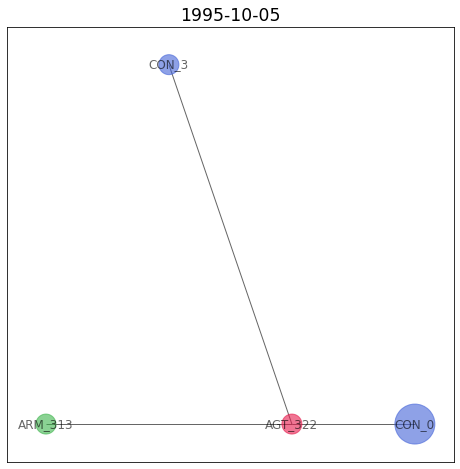

1995-10-11
['AGT_1645']


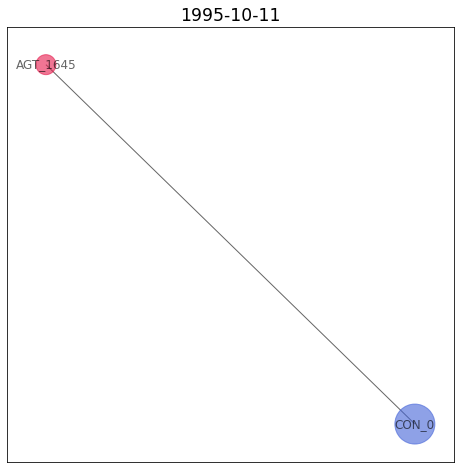

1995-10-23
['AGT_1201']


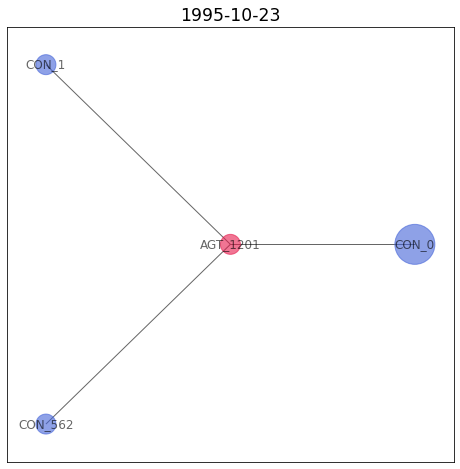

1995-11-10
['AGT_2']


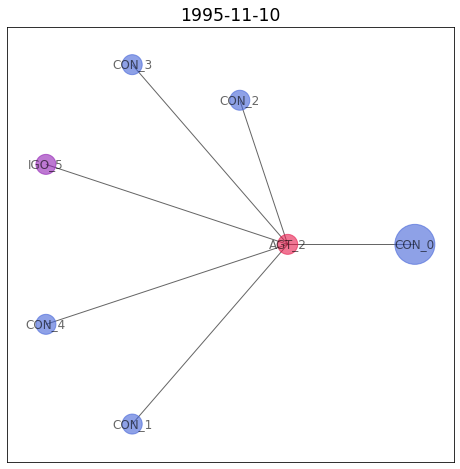

1995-11-21
['AGT_389', 'AGT_1289']


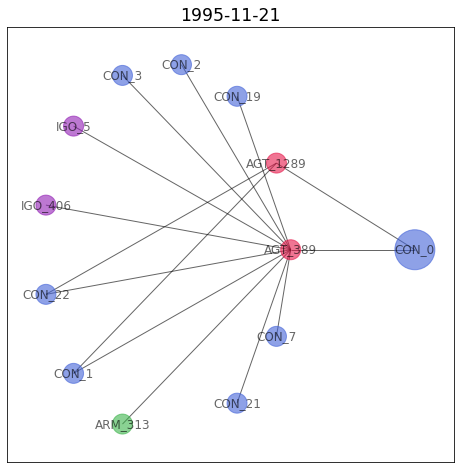

1995-12-09
['AGT_1030']


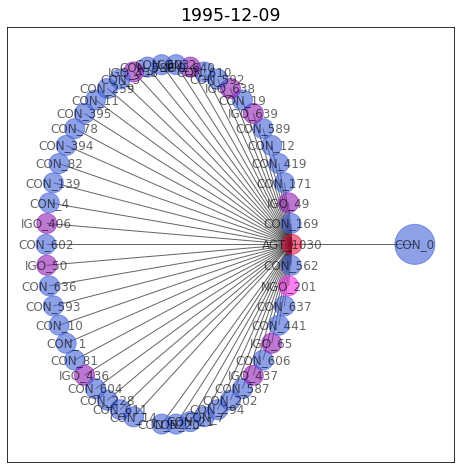

1995-12-14
['AGT_1320']


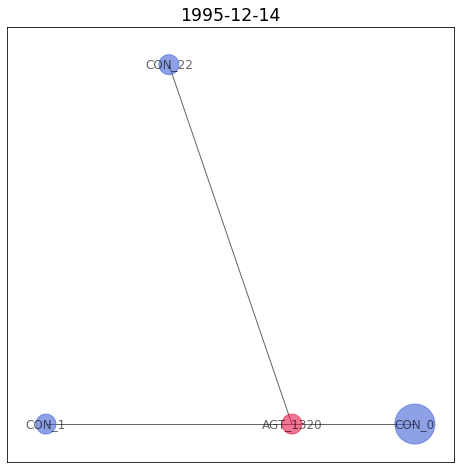

1996-03-30
['AGT_1205']


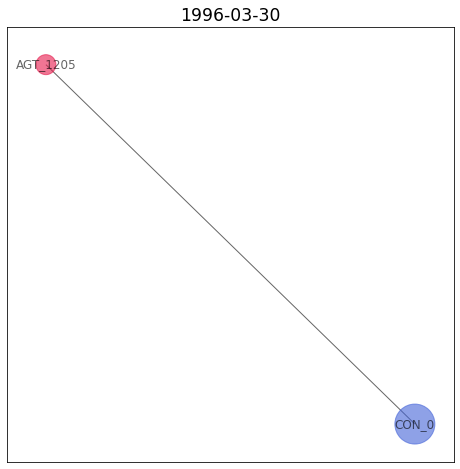

1996-04-25
['AGT_311', 'AGT_1206']


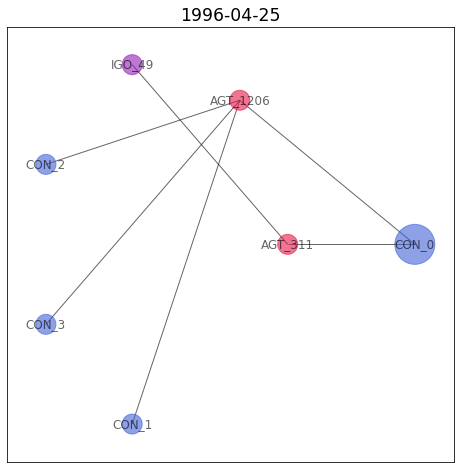

1996-10-03
['AGT_1903']


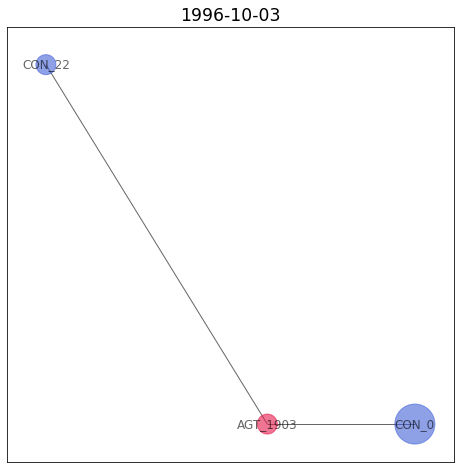

1996-12-02
['AGT_1207']


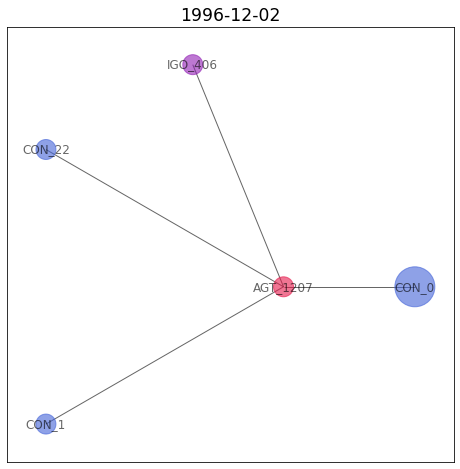

1997-02-28
['AGT_276']


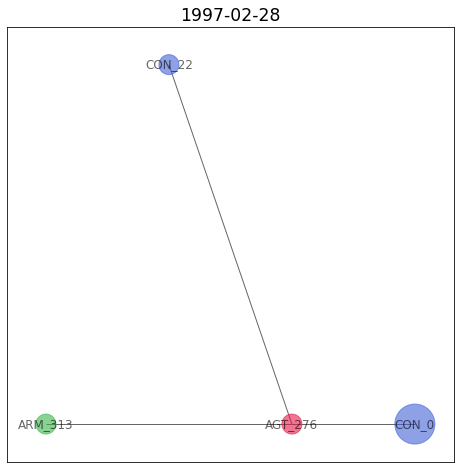

1997-08-06
['AGT_1212']


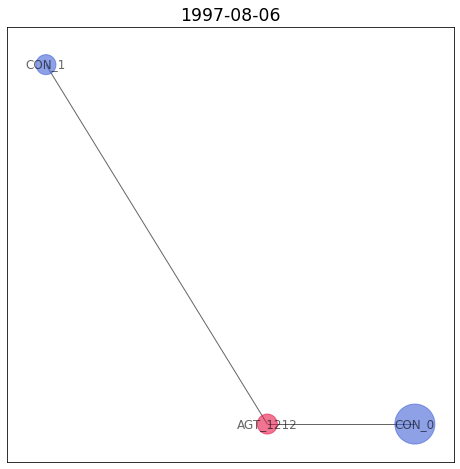

2022-06-12
['AGT_2447']


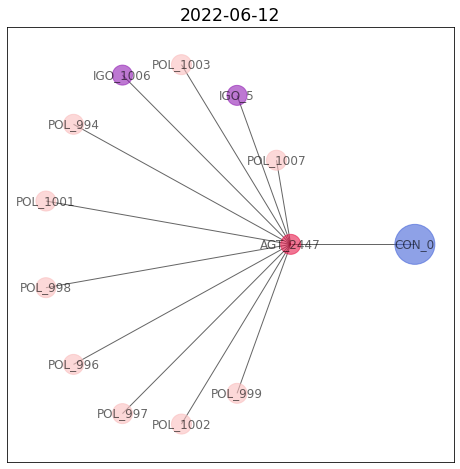

In [6]:
%run ./network_functions.py

def display_networkx_graph(actor_id,query_matrix,vertex_indices,adj_vertices,data_dict,title='',file=''):
    node_labels = {}
    node_sizes = []
    for i,index in enumerate(vertex_indices):
        node_id = adj_vertices[index]
        node_labels[i] = node_id
        
        if node_id == actor_id:
            centre_node = i
            node_sizes.append(1600)
        else:
            node_sizes.append(400)
        
    node_colors = [data_dict['color_map'][v.split('_')[0]] for _,v in node_labels.items()]
    graph = nx.from_numpy_array(query_matrix, create_using=nx.Graph)
    f = plt.figure(figsize=(8,8))
    pos = nx.circular_layout(graph)
    
    pos[centre_node] = np.array([2,0])

    nx.draw_networkx(graph,pos,labels=node_labels,node_color=node_colors,node_size=node_sizes,\
                     font_size=12,alpha=0.6)
    plt.grid(False)
    plt.title(title,fontsize='xx-large')
    if len(file) > 0:
        plt.savefig('../../outputs/' + file + '.png', bbox_inches='tight')
    plt.show()

# Decide on an actor
actor_id = 'CON_0'
print(get_actor_name(actor_id,data_dict))
actor_index = pp_data_dict['pp_actor_ids'].index(actor_id)
print(actor_index)

# Get the matrix column for the actor
agreement_indices = [index for index,v in enumerate(pp_data_dict['pp_matrix'][:,actor_index]) if v==1]
agreement_ids = [pp_data_dict['pp_agreement_ids'][index] for index in agreement_indices]

# Get dates actor signed an agreement
dates = []
for agreement_id in agreement_ids:
    dates.append(get_agreement_date(agreement_id,data_dict))

# Get all agreements signed on those dates
dates_dict = {}
for agreement_id in pp_data_dict['pp_agreement_ids']:
    date = get_agreement_date(agreement_id,data_dict)
    if not date in dates:
        continue
    if date in dates_dict:
        dates_dict[date].append(agreement_id)
    else:
        dates_dict[date]= [agreement_id]
        
dates = sorted(dates_dict.items(),key=lambda kv:kv[0])

adj_matrix,adj_vertices = adjacency_from_biadjacency(pp_data_dict)

for t in dates:
    print(t[0])
    agreement_ids = t[1]
    print(agreement_ids)
    agreement_indices = [pp_data_dict['pp_agreement_ids'].index(agreement_id) for\
                         agreement_id in agreement_ids]
    actor_indices = []
    for agreement_index in agreement_indices:
        actor_indices.extend([index for index,v in enumerate(pp_data_dict['pp_matrix'][agreement_index]) if\
                                  v==1])
        actor_indices = list(set(actor_indices))
    
    actor_ids = [pp_data_dict['pp_actor_ids'][index] for index in actor_indices]
    
    query_vertices = []
    query_vertices.extend(actor_ids)
    query_vertices.extend(agreement_ids)
    query_indices = [adj_vertices.index(vertex) for vertex in query_vertices]
    query_matrix,found_indices = get_query_matrix(query_indices,adj_matrix,operator='AND')
    display_networkx_graph(actor_id,query_matrix,found_indices,adj_vertices,data_dict,title=t[0],file=t[0])
    #break